In [1]:
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter


<h2>Reading the Data</h2>

In [2]:
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
project_data = pd.read_csv('/home/shivam/Desktop/train_data.csv',nrows=20000)

resource_data = pd.read_csv('/home/shivam/Desktop/resources.csv')


In [3]:
project_data.head(5)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2       21895  p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   
3          45  p246581  f3cb9bffbba169bef1a77b243e620b60           Mrs.   
4      172407  p104768  be1f7507a41f8479dc06f047086a39ec           Mrs.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   
2           AZ        2016-08-31 12:03:56             Grades 6-8   
3           KY        2016-10-06 21:16:17          Grades PreK-2   
4           TX        2016-07-11 01:10:09          Grades PreK-2   

            project_subject_categories     project_subject_subcategories  \
0                  Literacy & Language                     ESL, Literacy   
1    History & Civics, Health & Sports  Civics & Government, Team Sports   
2                      Health & Sports    Health & Wellness, Team Sports   
3  Literacy & Language, Math & Science             Literacy, Mathematics   
4                       Math & Science                       Mathematics   

                                       project_title  \
0   Educational Support for English Learners at Home   
1              Wanted: Projector for Hungry Learners   
2  Soccer Equipment for AWESOME Middle School Stu...   
3                             Techie Kindergarteners   
4                             Interactive Math Tools   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   
3  I work at a unique school filled with both ESL...   
4  Our second grade classroom next year will be m...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   
2  The students on the campus come to school know...             NaN   
3  My students live in high poverty conditions wi...             NaN   
4  For many students, math is a subject that does...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   
2             NaN  My students need shine guards, athletic socks,...   
3             NaN  My students need to engage in Reading and Math...   
4             NaN  My students need hands on practice in mathemat...   

   teacher_number_of_previously_posted_projects  project_is_approved  
0                                             0                    0  
1                                             7                    1  
2                                             1                    0  
3                                             4                    1  
4                                             1                    1

<h2>Preprocessing Categorical Features: project_grade_category</h2>

In [4]:


project_data['project_grade_category'].head(10)

project_data['project_grade_category'] = project_data['project_grade_category'].str.replace(' ','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace('-','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.lower()
project_data['project_grade_category'].value_counts()

grades_prek_2    8171
grades_3_5       6785
grades_6_8       3079
grades_9_12      1965
Name: project_grade_category, dtype: int64

<h2>Preprocessing Categorical Features: project_subject_categories</h2>

In [5]:
#
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' The ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace('&','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(',','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.lower()
project_data['project_subject_categories'].value_counts()


literacy_language                       4403
math_science                            3039
literacy_language_math_science          2707
health_sports                           1896
music_arts                               929
specialneeds                             742
literacy_language_specialneeds           742
appliedlearning                          694
math_science_literacy_language           435
appliedlearning_literacy_language        404
math_science_specialneeds                358
history_civics                           331
literacy_language_music_arts             302
appliedlearning_specialneeds             300
math_science_music_arts                  286
history_civics_literacy_language         257
warmth_care_hunger                       245
health_sports_specialneeds               240
math_science_appliedlearning             217
appliedlearning_math_science             189
appliedlearning_music_arts               157
health_sports_literacy_language          140
literacy_l

<h2>Preprocessing Categorical Features: teacher_prefix</h2>

In [6]:
#
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.replace('.','')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.lower()
project_data['teacher_prefix'].value_counts()


mrs        10420
ms          7222
mr          1908
teacher      449
Name: teacher_prefix, dtype: int64

<h2> Preprocessing Categorical Features: project_subject_subcategories</h2>

In [7]:
#
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' The ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace('&','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(',','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.lower()
project_data['project_subject_subcategories'].value_counts()


literacy                                1822
literacy_mathematics                    1519
literature_writing_mathematics          1124
literacy_literature_writing             1023
mathematics                              955
                                        ... 
economics_other                            1
environmentalscience_other                 1
parentinvolvement_performingarts           1
civics_government_college_careerprep       1
communityservice_nutritioneducation        1
Name: project_subject_subcategories, Length: 339, dtype: int64

<h2>Preprocessing Categorical Features: school_state</h2>

In [8]:
#
project_data['school_state'] = project_data['school_state'].str.lower()
project_data['school_state'].value_counts()


ca    2808
ny    1320
tx    1316
fl    1093
nc     967
il     769
sc     737
ga     725
mi     612
pa     575
oh     481
in     479
mo     475
la     458
wa     440
ok     430
ma     414
az     412
nj     399
va     352
ct     327
wi     322
tn     320
ut     318
al     300
nv     264
md     255
or     244
ky     231
co     228
ms     224
mn     212
ar     174
ks     129
id     124
ia     123
dc     100
me     100
hi      99
wv      99
nm      93
ak      66
sd      63
ne      59
de      55
ri      55
nh      51
mt      41
nd      26
wy      25
vt      11
Name: school_state, dtype: int64

In [9]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [10]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]


<h2>Preprocessing Text Features: project_title</h2>

In [11]:
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text
preprocessed_titles = preprocess_text(project_data['project_title'].values)


project_data['project_title']=preprocessed_titles

100%|██████████| 20000/20000 [00:01<00:00, 12331.01it/s]



<h2>Adding all essay and save in new column "essay"</h2>

In [12]:
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)


preprocessed_essays = preprocess_text(project_data['essay'].values)

project_data['essay']=preprocessed_essays


100%|██████████| 20000/20000 [00:36<00:00, 551.86it/s]


<h2>Merge column (price,quantity) from resource_data into project_data</h2>

In [13]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')

project_data['price'].head()


0    154.60
1    299.00
2    516.85
3    232.90
4     67.98
Name: price, dtype: float64

<h2>Drop all unwanted columns and save data in X, y variables</h2>

In [14]:
project_data.columns
data = project_data.drop(['project_is_approved','Unnamed: 0','project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4','teacher_id','project_submitted_datetime'], axis=1)

y = project_data['project_is_approved'].values
X = data
    

In [15]:
X.head()

id teacher_prefix school_state project_grade_category  \
0  p253737            mrs           in          grades_prek_2   
1  p258326             mr           fl             grades_6_8   
2  p182444             ms           az             grades_6_8   
3  p246581            mrs           ky          grades_prek_2   
4  p104768            mrs           tx          grades_prek_2   

       project_subject_categories project_subject_subcategories  \
0               literacy_language                  esl_literacy   
1    history_civics_health_sports  civics_government_teamsports   
2                   health_sports    health_wellness_teamsports   
3  literacy_language_math_science          literacy_mathematics   
4                    math_science                   mathematics   

                                     project_title  \
0        educational support english learners home   
1                 wanted projector hungry learners   
2  soccer equipment awesome middle school students   
3                           techie kindergarteners   
4                           interactive math tools   

                            project_resource_summary  \
0  My students need opportunities to practice beg...   
1  My students need a projector to help with view...   
2  My students need shine guards, athletic socks,...   
3  My students need to engage in Reading and Math...   
4  My students need hands on practice in mathemat...   

   teacher_number_of_previously_posted_projects  \
0                                             0   
1                                             7   
2                                             1   
3                                             4   
4                                             1   

                                               essay   price  quantity  
0  students english learners working english seco...  154.60        23  
1  students arrive school eager learn polite gene...  299.00         1  
2  true champions not always ones win guts mia ha...  516.85        22  
3  work unique school filled esl english second l...  232.90         4  
4  second grade classroom next year made around 2...   67.98         4

<h2>Break data into Train, CV and Test</h2>

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)    


In [17]:
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

(12800, 12) (12800,)
(3200, 12) (3200,)
(4000, 12) (4000,)


<h2>Checking percentage of unique class</h2>

In [89]:
(classes, counts) = np.unique(y_train, return_counts=True)
print(50*'*','Training lables',50*'*')
print('class 0','{0:.2f}'.format(counts[0]/(counts[0]+counts[1])*100))
print('class 1','{0:.2f}'.format(counts[1]/(counts[0]+counts[1])*100))


print(50*'*','CV lables',50*'*')
(classes, counts) = np.unique(y_cv, return_counts=True)
print('class 0','{0:.2f}'.format(counts[0]/(counts[0]+counts[1])*100))
print('class 1','{0:.2f}'.format(counts[1]/(counts[0]+counts[1])*100))


print(50*'*','Test lables',50*'*')
(classes, counts) = np.unique(y_test, return_counts=True)
print('class 0','{0:.2f}'.format(counts[0]/(counts[0]+counts[1])*100))
print('class 1','{0:.2f}'.format(counts[1]/(counts[0]+counts[1])*100))




************************************************** Training lables **************************************************
class 0 15.24
class 1 84.76
************************************************** CV lables **************************************************
class 0 15.25
class 1 84.75
************************************************** Test lables **************************************************
class 0 15.25
class 1 84.75


<h2>encoding categorical features: School State</h2>

In [90]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [91]:
# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_cv_state_ohe = vectorizer.transform(X_cv['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)


In [92]:

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_cv_state_ohe.shape, y_cv.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(12800, 51) (12800,)
(3200, 51) (3200,)
(4000, 51) (4000,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


<h2>#encoding categorical features: teacher_prefix</h2>

In [93]:

X_train['teacher_prefix']=X_train['teacher_prefix'].fillna('Mrs.') 
X_cv['teacher_prefix']=X_cv['teacher_prefix'].fillna('Mrs.')
X_test['tearcher_prefix']=X_test['teacher_prefix'].fillna('Mrs.')
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) 


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [94]:

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
X_cv_teacher_ohe = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values)


In [95]:
print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_cv_teacher_ohe.shape, y_cv.shape)
print(X_test_teacher_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)  


After vectorizations
(12800, 4) (12800,)
(3200, 4) (3200,)
(4000, 4) (4000,)
['mr', 'mrs', 'ms', 'teacher']


<h2>encoding categorical features: project_grade_category</h2>

In [96]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [97]:
# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_grade_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)


In [98]:
print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)
print(X_cv_grade_ohe.shape, y_cv.shape)
print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)   


After vectorizations
(12800, 4) (12800,)
(3200, 4) (3200,)
(4000, 4) (4000,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


<h2>Normalize feature: Price</h2>

In [99]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))

In [100]:
print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)   

After vectorizations
(12800, 1) (12800,)
(3200, 1) (3200,)
(4000, 1) (4000,)


In [101]:
project_data.head()

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc            mrs   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a             mr   
2       21895  p182444  3465aaf82da834c0582ebd0ef8040ca0             ms   
3          45  p246581  f3cb9bffbba169bef1a77b243e620b60            mrs   
4      172407  p104768  be1f7507a41f8479dc06f047086a39ec            mrs   

  school_state project_submitted_datetime project_grade_category  \
0           in        2016-12-05 13:43:57          grades_prek_2   
1           fl        2016-10-25 09:22:10             grades_6_8   
2           az        2016-08-31 12:03:56             grades_6_8   
3           ky        2016-10-06 21:16:17          grades_prek_2   
4           tx        2016-07-11 01:10:09          grades_prek_2   

       project_subject_categories project_subject_subcategories  \
0               literacy_language                  esl_literacy   
1    history_civics_health_sports  civics_government_teamsports   
2                   health_sports    health_wellness_teamsports   
3  literacy_language_math_science          literacy_mathematics   
4                    math_science                   mathematics   

                                     project_title  \
0        educational support english learners home   
1                 wanted projector hungry learners   
2  soccer equipment awesome middle school students   
3                           techie kindergarteners   
4                           interactive math tools   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   
3  I work at a unique school filled with both ESL...   
4  Our second grade classroom next year will be m...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   
2  The students on the campus come to school know...             NaN   
3  My students live in high poverty conditions wi...             NaN   
4  For many students, math is a subject that does...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   
2             NaN  My students need shine guards, athletic socks,...   
3             NaN  My students need to engage in Reading and Math...   
4             NaN  My students need hands on practice in mathemat...   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                             0                    0   
1                                             7                    1   
2                                             1                    0   
3                                             4                    1   
4                                             1                    1   

                                               essay   price  quantity  
0  students english learners working english seco...  154.60        23  
1  students arrive school eager learn polite gene...  299.00         1  
2  true champions not always ones win guts mia ha...  516.85        22  
3  work unique school filled esl english second l...  232.90         4  
4  second grade classroom next year made around 2...   67.98         4

<h2>Tfidf featurization:essay</h2>

In [102]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tfidf = TfidfVectorizer(min_df=10,ngram_range=(1,2))
vectorizer_tfidf.fit(X_train['essay'].values)
X_train_essay_tfidf = vectorizer_tfidf.transform(X_train['essay'].values)
X_cv_essay_tfidf = vectorizer_tfidf.transform(X_cv['essay'].values)
X_test_essay_tfidf = vectorizer_tfidf.transform(X_test['essay'].values)

In [103]:
print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_cv_essay_tfidf.shape, y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
print("="*100)

After vectorizations
(12800, 27931) (12800,)
(3200, 27931) (3200,)
(4000, 27931) (4000,)


<h2>Tfidf featurization:project title</h2>

In [104]:
vectorizer_tfidf = TfidfVectorizer(min_df=10,ngram_range=(1,2))
vectorizer_tfidf.fit(X_train['project_title'].values)
X_train_project_title_tfidf = vectorizer_tfidf.transform(X_train['project_title'].values)
X_cv_project_title_tfidf = vectorizer_tfidf.transform(X_cv['project_title'].values)
X_test_project_title_tfidf = vectorizer_tfidf.transform(X_test['project_title'].values)


In [105]:
print("After vectorizations")
print(X_train_project_title_tfidf.shape, y_train.shape)
print(X_cv_project_title_tfidf.shape, y_cv.shape)
print(X_test_project_title_tfidf.shape, y_test.shape)
print("="*100)

After vectorizations
(12800, 956) (12800,)
(3200, 956) (3200,)
(4000, 956) (4000,)


<h2>Combine all encoding, tfidf feature in sparse matrix</h2>

In [106]:
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_tfidf,X_train_project_title_tfidf, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe,X_train_price_norm)).tocsr()
X_cr = hstack((X_cv_essay_tfidf,X_cv_project_title_tfidf, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_grade_ohe, X_cv_price_norm)).tocsr()
X_te = hstack((X_test_essay_tfidf,X_test_project_title_tfidf, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_price_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(12800, 28947) (12800,)
(3200, 28947) (3200,)
(4000, 28947) (4000,)


<h2>Randomized Search</h2>

In [107]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
param_dist = {"max_depth": [1,5,10,50],
              "min_samples_leaf": [5,10,100,500],
              "criterion": ["gini", "entropy"]}

tree=DecisionTreeClassifier(class_weight = 'balanced')


clf = RandomizedSearchCV(tree, param_dist, cv=3, scoring='roc_auc',return_train_score=True)

clf.fit(X_tr, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_min_samples_leaf', 'param_max_depth', 'param_criterion',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'split0_train_score', 'split1_train_score', 'split2_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

<h2>Ploting 3d Graph (min_sample_leaf,max_depth,score)</h2>

In [108]:
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
import numpy as np

In [109]:
x1=results.param_min_samples_leaf
y1=results.param_max_depth
z1=results.mean_train_score
x2=results.param_min_samples_leaf
y2=results.param_max_depth
z2=results.mean_test_score

In [110]:
trace1 = go.Scatter3d(x=x1,y=y1,z=z1, name = 'train')
trace2 = go.Scatter3d(x=x2,y=y2,z=z2, name = 'Cross validation')
data = [trace1,trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

<h2>Grid Search CV</h2>

In [111]:
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
param_grid = {"max_depth": [1,5,10,50],
              "min_samples_leaf": [5,10,100,500],
              "criterion": ["gini", "entropy"]}
tree=DecisionTreeClassifier(class_weight = 'balanced')

clf=GridSearchCV(tree,param_grid,cv=3,scoring='roc_auc')

clf.fit(X_tr, y_train)

print("Best cross-validation score: {:.2f}".format(clf.best_score_))
print("Best parameters: ", clf.best_params_)

results = pd.DataFrame.from_dict(clf.cv_results_)
results.columns
import pandas as pd
pvt = pd.pivot_table(pd.DataFrame(clf.cv_results_),
    values='mean_test_score', index='param_max_depth', columns='param_min_samples_leaf')

Best cross-validation score: 0.60
Best parameters:  {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 500}


<h2>Heat map of training</h2>

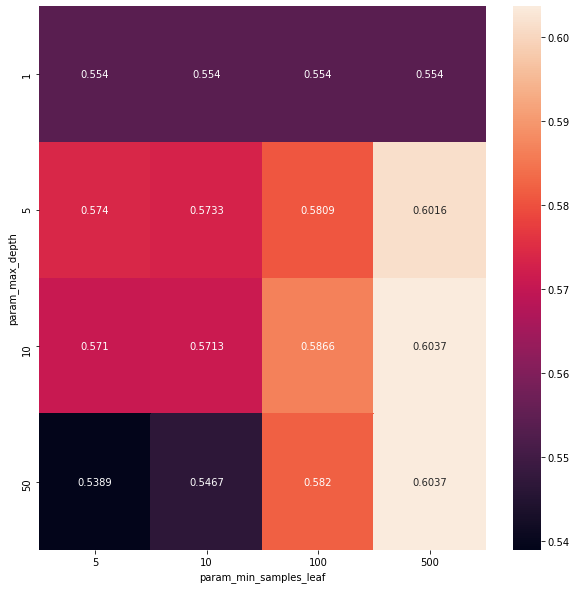

In [112]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(pvt,annot=True,fmt='.4g')

<h2>ROC of train data and test data</h2>

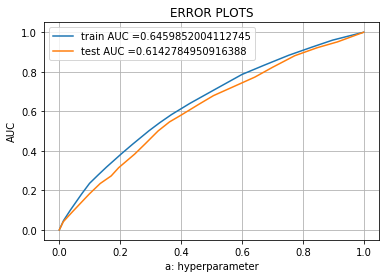

61.43


In [117]:
tree=DecisionTreeClassifier(max_depth=10,min_samples_leaf= 500)
from sklearn.metrics import roc_curve, auc


tree.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = tree.predict_proba(X_tr)[:,1]   
y_test_pred = tree.predict_proba(X_te)[:,1]


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("a: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()
test_auc_tfidf=auc(test_fpr, test_tpr)
print('{0:.2f}'.format(test_auc_tfidf*100))


<h2>Confusion Matrix</h2>

In [118]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

In [119]:
def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.3683823592288891 for threshold 0.856


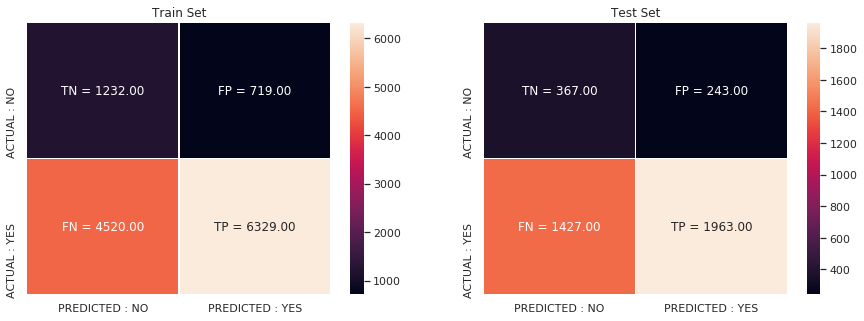

In [120]:
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

con_m_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
con_m_test = (confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(15,5))
labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),con_m_test.flatten())])).reshape(2,2)

sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()

<h2>Plot wordcloud of essay text of these `false positive data points`</h2>

In [121]:
p=predict_with_best_t(y_test_pred, best_t)

In [122]:
text=[]
for i in range(len(p)):
    if (p[i]==1 and y_test[i]==0):
        text.append(project_data['essay'][i])

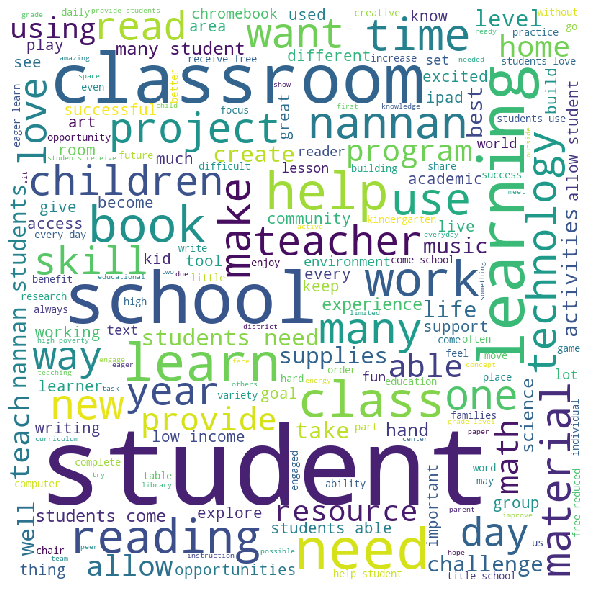

In [123]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd

comment_words = ' '
stopwords = set(STOPWORDS) 


for val in text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words+' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

<h2>Box Plot with the `price` of these `false positive data points`</h2>

In [124]:
price=[]
for i in range(len(p)):
    if (p[i]==1 and y_test[i]==0):
        price.append(project_data['price'][i])

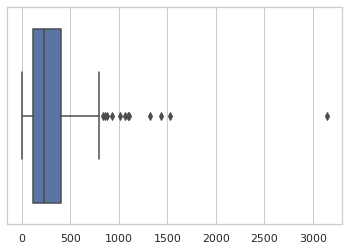

In [125]:
import seaborn as sns
sns.set(style="whitegrid")

ax = sns.boxplot(x=price)



<h2>Plot the pdf with the `teacher_number_of_previously_posted_projects` of these `false positive data points`</h2>

In [126]:
previously_posted_projects=[]
for i in range(len(p)):
    if (p[i]==1 and y_test[i]==0):
        previously_posted_projects.append(project_data['teacher_number_of_previously_posted_projects'][i])



[0.9382716  0.04526749 0.00823045 0.         0.00411523 0.
 0.         0.         0.         0.00411523]


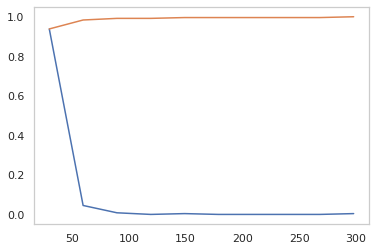

In [127]:
counts, bin_edges = np.histogram(previously_posted_projects, bins=10, density = True)
pdf = counts/(sum(counts))
print(pdf)
plt.grid()

cdf = np.cumsum(pdf)
plt.plot(bin_edges[1:],pdf)
plt.plot(bin_edges[1:], cdf)

<h2> Avg word2vec<h2>

In [128]:

def loadGloveModel(gloveFile):
    
    print ("Loading Glove Model")
    
    f = open(gloveFile,'r', encoding = 'utf8')
    
    model = {}
    
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    
    print ("Done.",len(model)," words loaded!")
    
    return model

In [129]:
model = loadGloveModel('/home/shivam/Desktop/assignment 11/glove.6B.50d.txt')

1241it [00:00, 12404.63it/s]

Loading Glove Model


400000it [00:23, 16677.08it/s]

Done. 400000  words loaded!


In [130]:

glove_words = set(model.keys())

In [131]:
# average Word2Vec
# compute average word2vec for each review.
def func(wordlist):
    
  train_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
  for sentence in tqdm(wordlist): # for each review/sentence
    vector = np.zeros(50) # as word vectors are of zero length # we are taking the 300dimensions very large
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    train_avg_w2v_vectors.append(vector)
    
  print(len(train_avg_w2v_vectors))
  print(len(train_avg_w2v_vectors[0]))
  return train_avg_w2v_vectors

In [132]:
train_avg_w2v_vectors_essay=func(X_train['essay'])
test_avg_w2v_vectors_essay=func(X_test['essay'])
cv_avg_w2v_vectors_essay=func(X_cv['essay'])

  5%|▍         | 188/4000 [00:00<00:02, 1871.83it/s]

12800
50


  5%|▌         | 170/3200 [00:00<00:01, 1694.69it/s]

4000
50


100%|██████████| 3200/3200 [00:01<00:00, 1795.71it/s]

3200
50


In [133]:
#for titles
cv_avg_w2v_vectors_project_title=func(X_cv['project_title'])
test_avg_w2v_vectors_project_title=func(X_test['project_title'])
train_avg_w2v_vectors_project_title=func(X_train['project_title'])

  0%|          | 0/12800 [00:00<?, ?it/s]

3200
50
4000
50


100%|██████████| 12800/12800 [00:00<00:00, 31744.93it/s]

12800
50


<h2>Merging....</h2>

In [134]:
from scipy.sparse import hstack
X_tr_w2v = hstack((train_avg_w2v_vectors_essay,train_avg_w2v_vectors_project_title, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe,X_train_price_norm)).tocsr()
X_cr_w2v = hstack((cv_avg_w2v_vectors_essay,cv_avg_w2v_vectors_project_title, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_grade_ohe, X_cv_price_norm)).tocsr()
X_te_w2v = hstack((test_avg_w2v_vectors_essay,test_avg_w2v_vectors_project_title, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_price_norm)).tocsr()

print("Final Data matrix")
print(X_tr_w2v.shape, y_train.shape)
print(X_cr_w2v.shape, y_cv.shape)
print(X_te_w2v.shape, y_test.shape)
print("="*100)

Final Data matrix
(12800, 160) (12800,)
(3200, 160) (3200,)
(4000, 160) (4000,)


<h2>Grid Search for w2v</h2>

In [60]:
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
param_grid = {"max_depth": [1,5,10,50],
              "min_samples_leaf": [5,10,100,500],
              "criterion": ["gini", "entropy"]}
tree=DecisionTreeClassifier(class_weight = 'balanced')

clf=GridSearchCV(tree,param_grid,cv=3,scoring='roc_auc')

clf.fit(X_tr_w2v, y_train)

print("Best cross-validation score: {:.2f}".format(clf.best_score_))
print("Best parameters: ", clf.best_params_)

results = pd.DataFrame.from_dict(clf.cv_results_)
results.columns
import pandas as pd
pvt = pd.pivot_table(pd.DataFrame(clf.cv_results_),
    values='mean_test_score', index='param_max_depth', columns='param_min_samples_leaf')

Best cross-validation score: 0.59
Best parameters:  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 100}


<h2>Heat map</h2>

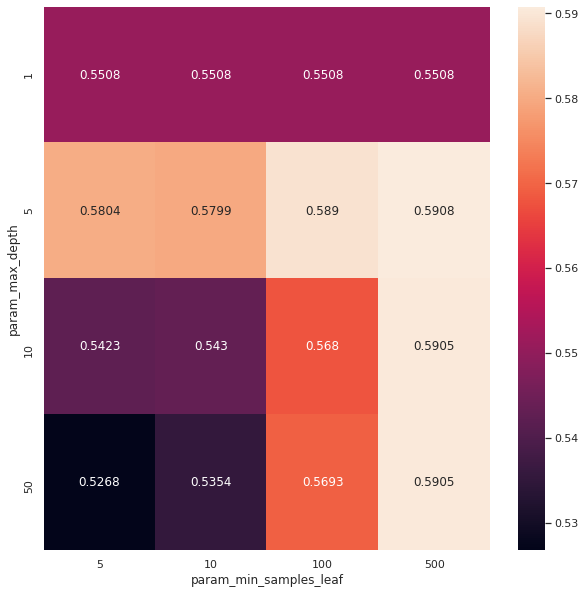

In [61]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(pvt,annot=True,fmt='.4g')


<h2>ROC</h2>

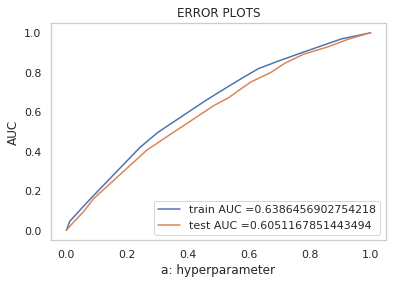

60.51


In [137]:
tree=DecisionTreeClassifier(max_depth=5,min_samples_leaf= 500)
from sklearn.metrics import roc_curve, auc


tree.fit(X_tr_w2v, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = tree.predict_proba(X_tr_w2v)[:,1]   
y_test_pred = tree.predict_proba(X_te_w2v)[:,1]


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("a: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()
test_auc_avg_w2v=auc(test_fpr, test_tpr)
print('{0:.2f}'.format(test_auc_avg_w2v*100))

<h2>confusion matrix</h2>

In [138]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

In [139]:
def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.35670177057514596 for threshold 0.851


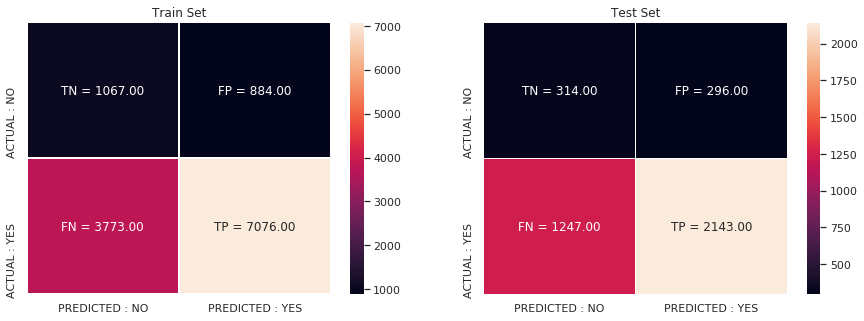

In [140]:
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

con_m_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
con_m_test = (confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(15,5))
labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),con_m_test.flatten())])).reshape(2,2)

sns.heatmap(con_m_train, linewidths=.9, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()



<h2>Tfidf_W2V Using Golve</h2>

In [141]:
#For essay
tfidf_model_essay = TfidfVectorizer()
tfidf_model_essay.fit(X_train['essay'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model_essay.get_feature_names(), list(tfidf_model_essay.idf_)))
tfidf_words_essay = set(tfidf_model_essay.get_feature_names())

In [142]:
def tf_idf_w2v(sent_list):
    train_title_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(sent_list): # for each review/sentence
        vector = np.zeros(50) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split():#.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words_essay):
              #vec = model.wv[word]  
              vec = model[word] # getting the vector for each word
# here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
              tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
              vector += (vec * tf_idf) # calculating tfidf weighted w2v
              tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        train_title_tfidf_w2v_vectors.append(vector)
    print(len(train_title_tfidf_w2v_vectors))
    print(len(train_title_tfidf_w2v_vectors[0]))
    return train_title_tfidf_w2v_vectors

In [143]:
#For essay
X_train_tfidf_w2v_essay=tf_idf_w2v(X_train['essay'])
X_test_tfidf_w2v_essay=tf_idf_w2v(X_test['essay'])
X_cv_tfidf_w2v_essay=tf_idf_w2v(X_cv['essay'])

  0%|          | 19/4000 [00:00<00:21, 181.35it/s]

12800
50


  1%|          | 23/3200 [00:00<00:13, 227.91it/s]

4000
50


100%|██████████| 3200/3200 [00:13<00:00, 230.26it/s]

3200
50


In [144]:
#for titles
tfidf_model_project_title = TfidfVectorizer()
tfidf_model_project_title.fit(X_train['project_title'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model_project_title.get_feature_names(), list(tfidf_model_project_title.idf_)))
tfidf_words_project_title = set(tfidf_model_project_title.get_feature_names())


In [145]:
def tf_idf_w2v(sent_list):
    train_title_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(sent_list): # for each review/sentence
        vector = np.zeros(50) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split():#.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words_project_title):
              #vec = model.wv[word]  
              vec = model[word] # getting the vector for each word
# here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
              tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
              vector += (vec * tf_idf) # calculating tfidf weighted w2v
              tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        train_title_tfidf_w2v_vectors.append(vector)
    print(len(train_title_tfidf_w2v_vectors))
    print(len(train_title_tfidf_w2v_vectors[0]))
    return train_title_tfidf_w2v_vectors

In [146]:
X_train_tfidf_w2v_project=tf_idf_w2v(X_train['project_title'])
X_test_tfidf_w2v_project=tf_idf_w2v(X_test['project_title'])
X_cv_tfidf_w2v_project=tf_idf_w2v(X_cv['project_title'])

 37%|███▋      | 1488/4000 [00:00<00:00, 14875.23it/s]

12800
50


 44%|████▍     | 1416/3200 [00:00<00:00, 14157.79it/s]

4000
50


100%|██████████| 3200/3200 [00:00<00:00, 14587.44it/s]

3200
50


<h2>Merging...</h2>

In [147]:
from scipy.sparse import hstack
X_tr_tfidf_w2v = hstack((X_train_tfidf_w2v_essay,X_train_tfidf_w2v_project, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe,X_train_price_norm)).tocsr()
X_cr_tfidf_w2v = hstack((X_cv_tfidf_w2v_essay,X_cv_tfidf_w2v_project, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_grade_ohe, X_cv_price_norm)).tocsr()
X_te_tfidf_w2v = hstack((X_test_tfidf_w2v_essay,X_test_tfidf_w2v_project, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_price_norm)).tocsr()

print("Final Data matrix")
print(X_tr_tfidf_w2v.shape, y_train.shape)
print(X_cr_tfidf_w2v.shape, y_cv.shape)
print(X_te_tfidf_w2v.shape, y_test.shape)
print("="*100)

Final Data matrix
(12800, 160) (12800,)
(3200, 160) (3200,)
(4000, 160) (4000,)


<h2>Grid Search for tfidf_w2v</h2>

In [73]:
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
param_grid = {"max_depth": [1,5,10,50],
              "min_samples_leaf": [5,10,100,500],
              "criterion": ["gini", "entropy"]}
tree=DecisionTreeClassifier(class_weight = 'balanced')

clf=GridSearchCV(tree,param_grid,cv=3,scoring='roc_auc')

clf.fit(X_tr_tfidf_w2v, y_train)

print("Best cross-validation score: {:.2f}".format(clf.best_score_))
print("Best parameters: ", clf.best_params_)

results = pd.DataFrame.from_dict(clf.cv_results_)
results.columns
import pandas as pd
pvt = pd.pivot_table(pd.DataFrame(clf.cv_results_),
    values='mean_test_score', index='param_max_depth', columns='param_min_samples_leaf')

Best cross-validation score: 0.61
Best parameters:  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 500}


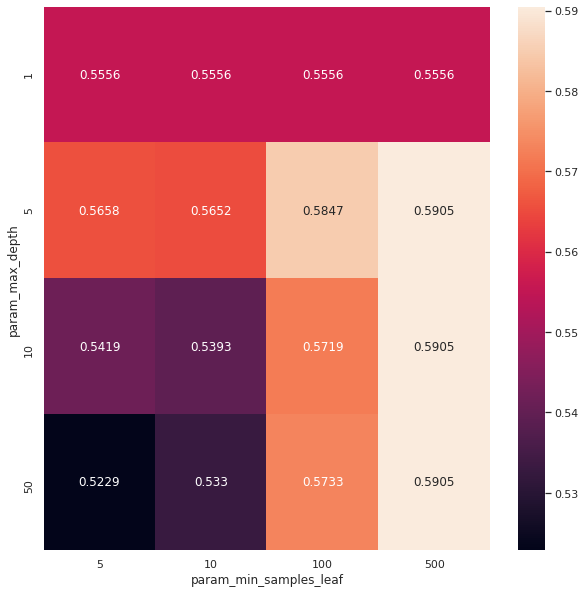

In [119]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(pvt,annot=True,fmt='.4g')

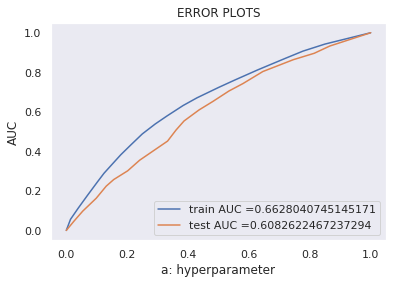

60.83


In [149]:
tree=DecisionTreeClassifier(max_depth=10,min_samples_leaf= 500)
from sklearn.metrics import roc_curve, auc


tree.fit(X_tr_tfidf_w2v, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = tree.predict_proba(X_tr_tfidf_w2v)[:,1]   
y_test_pred = tree.predict_proba(X_te_tfidf_w2v)[:,1]


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("a: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()
test_auc_tfidf_w2v=auc(test_fpr, test_tpr)
print('{0:.2f}'.format(test_auc_tfidf_w2v*100))


In [150]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t


In [151]:
def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.3893393486534956 for threshold 0.847


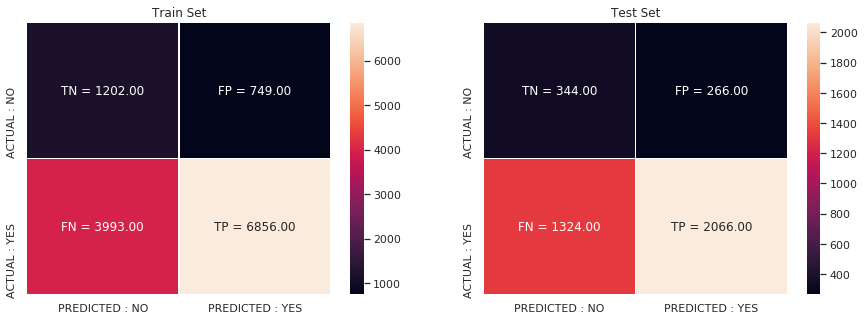

In [152]:
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

con_m_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
con_m_test = (confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(15,5))
labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),con_m_test.flatten())])).reshape(2,2)

sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()



<h2>Task 2 ----With feature importance</h2>

In [153]:
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_tfidf,X_train_project_title_tfidf, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe,X_train_price_norm)).tocsr()
X_cr = hstack((X_cv_essay_tfidf,X_cv_project_title_tfidf, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_grade_ohe, X_cv_price_norm)).tocsr()
X_te = hstack((X_test_essay_tfidf,X_test_project_title_tfidf, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_price_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(12800, 28947) (12800,)
(3200, 28947) (3200,)
(4000, 28947) (4000,)


In [154]:
from sklearn.model_selection import GridSearchCV
param_grid = {"max_depth": [1,5,10,50],
              "min_samples_leaf": [5,10,100,500],
              "criterion": ["gini", "entropy"]}

clf=GridSearchCV(tree,param_grid,cv=3,scoring='roc_auc')

clf.fit(X_tr, y_train)

print("Best cross-validation score: {:.2f}".format(clf.best_score_))
print("Best parameters: ", clf.best_params_)

results = pd.DataFrame.from_dict(clf.cv_results_)
results.columns
import pandas as pd
pvt = pd.pivot_table(pd.DataFrame(clf.cv_results_),
    values='mean_test_score', index='param_max_depth', columns='param_min_samples_leaf')

Best cross-validation score: 0.61
Best parameters:  {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 500}


In [155]:
from sklearn.tree import DecisionTreeClassifier
tree=DecisionTreeClassifier(max_depth=5,min_samples_leaf= 500,class_weight='balanced')
from sklearn.metrics import roc_curve, auc


tree.fit(X_tr, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=500, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [156]:
feature_impce = tree.feature_importances_
relevant_features = []
cols = []

for i, val in enumerate(feature_impce):     #dtc2 is optimal decision tree model for set 2.
    if val > 0:
        relevant_features.append(feature_impce[i])
        cols.append(i)

In [158]:
X_tr_new = X_tr.todense()[:, cols]
X_test_new = X_te.todense()[:, cols]

In [159]:
from sklearn.model_selection import GridSearchCV
param_grid = {"max_depth": [1,5,10,50],
              "min_samples_leaf": [5,10,100,500],
              "criterion": ["gini", "entropy"]}

clf=GridSearchCV(tree,param_grid,cv=3,scoring='roc_auc')

clf.fit(X_tr_new, y_train)

print("Best cross-validation score: {:.2f}".format(clf.best_score_))
print("Best parameters: ", clf.best_params_)

results = pd.DataFrame.from_dict(clf.cv_results_)
results.columns
import pandas as pd
pvt = pd.pivot_table(pd.DataFrame(clf.cv_results_),
    values='mean_test_score', index='param_max_depth', columns='param_min_samples_leaf')

Best cross-validation score: 0.61
Best parameters:  {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 500}


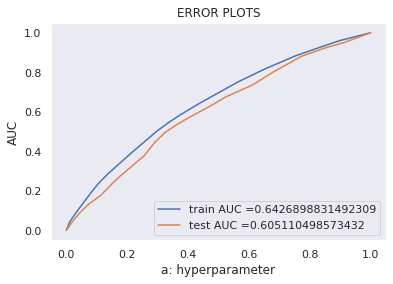

60.51


In [160]:
tree=DecisionTreeClassifier(max_depth=10,min_samples_leaf= 500)
from sklearn.metrics import roc_curve, auc


tree.fit(X_tr_new, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = tree.predict_proba(X_tr_new)[:,1]   
y_test_pred = tree.predict_proba(X_test_new)[:,1]


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("a: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()
test_auc_feature_imp=auc(test_fpr, test_tpr)
print('{0:.2f}'.format(test_auc_feature_imp*100))


In [167]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

In [168]:
def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


the maximum value of tpr*(1-fpr) 0.365585473466696 for threshold 0.85


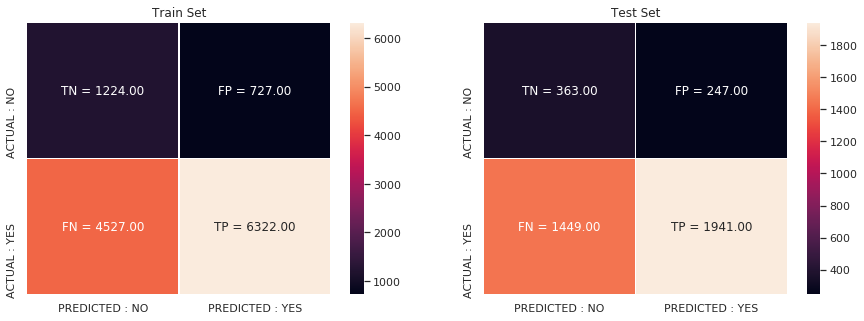

In [169]:
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

con_m_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
con_m_test = (confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
fig, ax = plt.subplots(1,2, figsize=(15,5))
labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(),con_m_test.flatten())])).reshape(2,2)

sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_train, fmt = '', ax=ax[0])
sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : NO', 'PREDICTED : YES'],yticklabels=['ACTUAL : NO', 'ACTUAL : YES'], annot = labels_test, fmt = '', ax=ax[1])
ax[0].set_title('Train Set')
ax[1].set_title('Test Set')
plt.show()


In [174]:
p=predict_with_best_t(y_test_pred, best_t)


text=[]
for i in range(len(p)):
    if (p[i]==1 and y_test[i]==0):
        text.append(project_data['essay'][i])


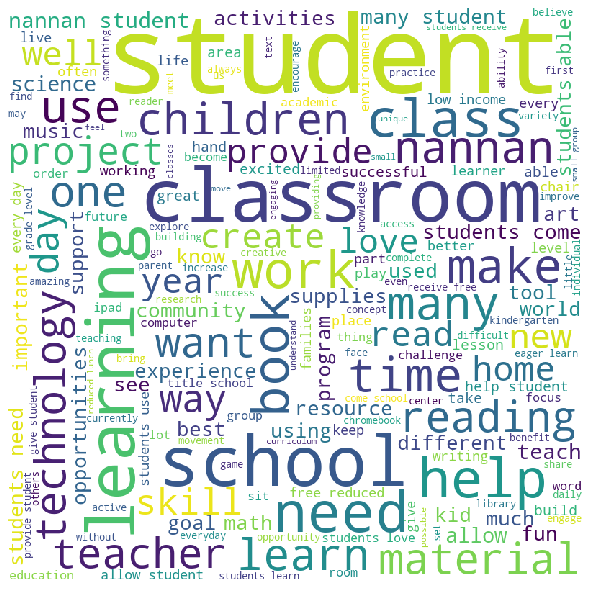

In [175]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd

comment_words = ' '
stopwords = set(STOPWORDS) 


for val in text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words+' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

<h2>Conclusion</h2>

In [166]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Vectorizer", "Hyper Parameter", "AUC"]
optimal=[10,500]
table.add_row(["TFIDF", optimal, test_auc_tfidf])
table.add_row(["AVG_W2V", optimal, test_auc_avg_w2v])
table.add_row(["TFIDF_W2V", optimal, test_auc_tfidf_w2v])
table.add_row(["TFIDF FEATURE_IMP", optimal, test_auc_feature_imp])
print(table)

+-------------------+-----------------+--------------------+
|     Vectorizer    | Hyper Parameter |        AUC         |
+-------------------+-----------------+--------------------+
|       TFIDF       |    [10, 500]    | 0.6142784950916388 |
|      AVG_W2V      |    [10, 500]    | 0.6051167851443494 |
|     TFIDF_W2V     |    [10, 500]    | 0.6082622467237294 |
| TFIDF FEATURE_IMP |    [10, 500]    | 0.605110498573432  |
+-------------------+-----------------+--------------------+
